In [1]:
from __future__ import (absolute_import, division, print_function, unicode_literals)
import random
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.cm as cm
import seaborn as sns
plt.style.use('ggplot')

from mltools.dataManager import DataManager
from mltools.baseLearner import BaseLearner

%matplotlib inline

ImportError: No module named baseLearner

In [262]:
class DataManager:
    MISSING = float("infinity")

    def __init__(self, arff=None):
        """
        If matrix is provided, all parameters must be provided, and the new matrix will be
        initialized with the specified portion of the provided matrix.
        """
        if arff:
            self.load_arff(arff)
        else:
            pass

    def init_from(self, matrix, row_start, col_start, row_count, col_count):
        """Initialize the matrix with a portion of another matrix"""
        self.data = [matrix.data[row][col_start:col_start+col_count] for row in range(row_start, row_start+row_count)]
        self.attr_names = matrix.attr_names[col_start:col_start+col_count]
        self.str_to_enum = matrix.str_to_enum[col_start:col_start+col_count]    # array of dictionaries
        self.enum_to_str = matrix.enum_to_str[col_start:col_start+col_count]    # array of dictionaries
        return self

    def add_data(self, new_data):
        """Appends a copy of the specified portion of a matrix to this matrix"""
        self.data = np.vstack((self.data, new_data))

    def set_labels(self):
        self.labels = self.data[:,-1]
        self.data = self.data[:,:-1]

    def test_train_split(self, ratio=.8):
        self.shuffle()
        split_point = int(self.num_rows * ratio)
        x_train = self.data[:split_point,:]
        x_test = self.data[split_point:,:]
        y_train = self.labels[:split_point]
        y_test = self.labels[split_point:]
        return x_train, x_test, y_train, y_test

    def set_size(self, rows, cols):
        """Resize this matrix (and set all attributes to be continuous)"""
        self.data = [[0]*cols for row in range(rows)]
        self.attr_names = [""] * cols
        self.str_to_enum = {}
        self.enum_to_str = {}

    def load_arff(self, filename):
        """ Load data from an ARFF file """
        self.data = []
        self.attr_names = []
        self.str_to_enum = []
        self.enum_to_str = []
        reading_data = False

        rows = []           # we read data into array of rows, then convert into array of columns

        f = open(filename)
        for line in f.readlines():
            line = line.rstrip().upper()
            if len(line) > 0 and line[0] != '%':
                if not reading_data:
                    if line.startswith("@RELATION"):
                        self.dataset_name = line[9:].strip()
                    elif line.startswith("@ATTRIBUTE"):
                        attr_def = line[10:].strip()
                        if attr_def[0] == "'":
                            attr_def = attr_def[1:]
                            attr_name = attr_def[:attr_def.index("'")]
                            attr_def = attr_def[attr_def.index("'")+1:].strip()
                        else:
                            attr_name, attr_def = attr_def.split()

                        self.attr_names += [attr_name]

                        str_to_enum = {}
                        enum_to_str = {}
                        if not(attr_def == "REAL" or attr_def == "CONTINUOUS" or attr_def == "INTEGER"):
                            # attribute is discrete
                            assert attr_def[0] == '{' and attr_def[-1] == '}'
                            attr_def = attr_def[1:-1]
                            attr_vals = attr_def.split(",")
                            val_idx = 0
                            for val in attr_vals:
                                val = val.strip()
                                enum_to_str[val_idx] = val
                                str_to_enum[val] = val_idx
                                val_idx += 1

                        self.enum_to_str.append(enum_to_str)
                        self.str_to_enum.append(str_to_enum)

                    elif line.startswith("@DATA"):
                        reading_data = True

                else:
                    # reading data
                    row = []
                    val_idx = 0
                    # print("{}".format(line))
                    vals = line.split(",")
                    for val in vals:
                        val = val.strip()
                        if not val:
                            raise Exception("Missing data element in row with data '{}'".format(line))
                        else:
                            row += [float(self.MISSING if val == "?" else self.str_to_enum[val_idx].get(val, val))]

                        val_idx += 1

                    rows += [row]

        f.close()
        self.data=np.array(rows)
        self.set_labels()


    @property
    def num_rows(self):
        """Get the number of rows in the matrix"""
        return len(self.data)

    @property
    def num_cols(self):
        """Get the number of columns (or attributes) in the matrix"""
        return len(self.attr_names)

    
    def attr_name(self, col):
        """Get the name of the specified attribute"""
        return self.attr_names[col]

    def attr_value(self, attr, val):
        """
        Get the name of the specified value (attr is a column index)
        :param attr: index of the column
        :param val: index of the value in the column attribute list
        :return:
        """
        return self.enum_to_str[attr][val]

    def value_count(self, col):
        """
        Get the number of values associated with the specified attribute (or columnn)
        0=continuous, 2=binary, 3=trinary, etc.
        """
        return len(self.enum_to_str[col]) if len(self.enum_to_str) > 0 else 0

    def shuffle(self):
        """Shuffle the row order. If a buddy Matrix is provided, it will be shuffled in the same order."""
        idx = np.random.permutation(self.num_rows)
        self.data = self.data[idx]
        self.labels = self.labels[idx]

     
    def mean(self):
        return np.mean(self.data, axis=0)

    def column_mean(self, col):
        """Get the mean of the specified column"""
        a = np.ma.masked_equal(self.data[:,col], self.MISSING).compressed()
        return np.mean(a)

    def column_min(self, col):
        """Get the min value in the specified column"""
        a = np.ma.masked_equal(self.data[:,col], self.MISSING).compressed()
        return np.min(a)

    def column_max(self, col):
        """Get the max value in the specified column"""
        a = np.ma.masked_equal(self.data[:,col], self.MISSING).compressed()
        return np.max(a)

    def most_common_value(self, col):
        """Get the most common value in the specified column"""
        a = np.ma.masked_equal(self.data[:,col], self.MISSING).compressed()
        scores = np.unique(np.ravel(a))       # get ALL unique values
        testshape = list(a.shape)
        testshape[axis] = 1
        oldmostfreq = np.zeros(testshape)
        oldcounts = np.zeros(testshape)

        for score in scores:
            template = (a == score)
            counts = np.expand_dims(np.sum(template, axis),axis)
            mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
            oldcounts = np.maximum(counts, oldcounts)
            oldmostfreq = mostfrequent
        
        return mostfrequent

    def normalize(self):
        """Normalize each column of continuous values"""
        for i in range(self.num_cols):
            if self.value_count(i) == 0:     # is continuous
                min_val = self.column_min(i)
                max_val = self.column_max(i)
                for j in range(self.num_rows):
                    v = self.data[j, i]
                    if v != self.MISSING:
                        self.data[j, i] = (v - min_val)/(max_val - min_val)
                        
    def __str__(self):
        outString = ""
        print("@RELATION {}".format(self.dataset_name))
        for i in range(len(self.attr_names)):
            print("@ATTRIBUTE {}".format(self.attr_names[i]), end="")
            if self.value_count(i) == 0:
                print(" CONTINUOUS")
            else:
                print(" {{{}}}".format(", ".join(self.enum_to_str[i].values())))

        print("@DATA")
        print(self.data)

    def __str__(self):
        outString = ""
        outString += "@RELATION {}".format(self.dataset_name)
        for i in range(len(self.attr_names)):
            outString += "@ATTRIBUTE {}\n".format(self.attr_names[i])
            if self.value_count(i) == 0:
                outString += " CONTINUOUS\n"
            else:
                outString += " {{{}}}\n".format(", ".join(self.enum_to_str[i].values()))

        outString += "@DATA\n"
        outString += str(self.data)
        return outString
        


In [ ]:
def print_decision_boundry(X, Y, model, h=.01, name="s.png"):
    plt.figure(figsize=(8,8))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(4, 3))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Accent,s=50)

    plt.title("Non-Seperable Data")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

In [278]:
class Perceptron(BaseLearner):
    """ My implementation of the perceptron algorithm."""
    
    def train(self, x_train, y_train, lr=.1, epochs=100, tol=.99, verbose=True):
        # Add Bias
        x_train = np.hstack((np.ones((x_train.shape[0],1)), x_train))
        n, d = x_train.shape
        
        # Initialize Weights
        self.w = np.random.randn(d) * .1
        acc_list = []
        j, acc, acc_cnt = 0, 0, 0
        last_acc = 0
        misclass = []
        
        while j < epochs and acc_cnt < 5:
            #Shuffle the data
            idx = np.random.permutation(n)
            x_train = x_train[idx]
            y_train = y_train[idx]
            for i in range(n):
                predicted = np.dot(self.w, x_train[i])
                predicted = 0 if predicted < 0 else 1
                self.w = self.w + (lr * (y_train[i] - predicted) * x_train[i])
                
            # Calc Loss
            y_hat = np.dot(x_train, self.w)
            y_hat[y_hat > 0] = 1
            y_hat[y_hat <= 0] = 0
            acc = accuracy_score(y_train, y_hat)
            
            # Stopping criteria
            if acc <= last_acc:
                acc_cnt += 1
            else:
                last_acc = acc
                acc_cnt = 0
                
            # Store Metrics
            acc_list.append(acc)
            con_mat = confusion_matrix(y_train, self.predict(x_train[:,1:]))
            misclass.append(con_mat[0,1]+con_mat[1,0])

            if verbose:
                print("[{}] Acc: {}".format(j, acc))   
            j += 1
            
        self.acc_list = acc_list
        self.misclass = misclass
        return
            
    
    def predict(self, x_test, binary=True):
        x_test = np.hstack((np.ones((x_test.shape[0], 1)), x_test))
        probs = np.dot(x_test, self.w)
        if binary:
            probs[probs > 0] = 1
            probs[probs <= 0] = 0
        return probs

# Problem 3

In [127]:
data = DataManager(arff='./datasets/seperable.arff')
x_train, x_test, y_train, y_test = data.test_train_split()

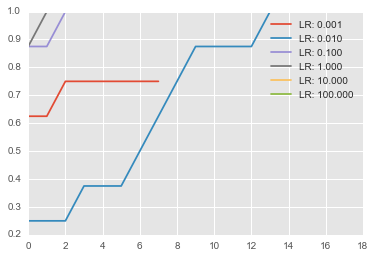

In [135]:
for l in [.001, .01, .1, 1, 10, 100]:  
    model = Perceptron()
    acc_list, _ = model.train(data.data, data.labels, lr=l, verbose=False)
    y_hat = model.predict(x_test)
    plt.plot(acc_list, label='LR: %.3f'%l)
plt.legend(loc='bottom right')
plt.savefig('./images/seperable1.png')
plt.show()

In [138]:
data = DataManager(arff='./datasets/nonseperable.arff')
x_train, x_test, y_train, y_test = data.test_train_split()

[0] Acc: 0.5
[1] Acc: 0.5
[2] Acc: 0.5
[3] Acc: 0.5
[4] Acc: 0.5
[5] Acc: 0.5
[0] Acc: 0.625
[1] Acc: 0.625
[2] Acc: 0.625
[3] Acc: 0.625
[4] Acc: 0.5
[5] Acc: 0.5
[0] Acc: 0.625
[1] Acc: 0.5
[2] Acc: 0.5
[3] Acc: 0.625
[4] Acc: 0.625
[5] Acc: 0.75
[6] Acc: 0.625
[7] Acc: 0.625
[8] Acc: 0.625
[9] Acc: 0.5
[10] Acc: 0.875
[11] Acc: 0.625
[12] Acc: 0.625
[13] Acc: 0.625
[14] Acc: 0.625
[15] Acc: 0.75
[0] Acc: 0.75
[1] Acc: 0.5
[2] Acc: 0.625
[3] Acc: 0.75
[4] Acc: 0.5
[5] Acc: 0.625
[0] Acc: 0.375
[1] Acc: 0.5
[2] Acc: 0.5
[3] Acc: 0.625
[4] Acc: 0.625
[5] Acc: 0.5
[6] Acc: 0.625
[7] Acc: 0.5
[8] Acc: 0.625
[0] Acc: 0.5
[1] Acc: 0.625
[2] Acc: 0.5
[3] Acc: 0.625
[4] Acc: 0.5
[5] Acc: 0.625
[6] Acc: 0.625


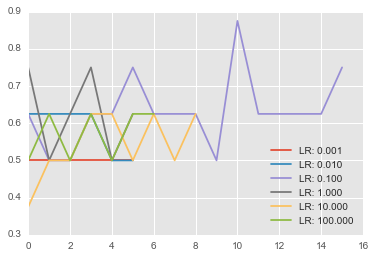

In [139]:
for l in [.001, .01, .1, 1, 10, 100]:  
    model = Perceptron()
    acc_list, _ = model.train(data.data, data.labels, lr=l)
    y_hat = model.predict(x_test)
    plt.plot(acc_list, label='LR: %.3f'%l)
plt.legend(loc='lower right')
plt.savefig('./images/nonseparable1.png')
plt.show()

# Problem 4

In [ ]:
data = DataManager(arff='./datasets/seperable.arff')
x_train, x_test, y_train, y_test = data.test_train_split()

model = Perceptron()
model.train(data.data, data.labels)
y_hat = model.predict(x_test)

In [ ]:
print_decision_boundry(data.data, data.labels, model, name="seperable.png")

In [ ]:
data = DataManager(arff='./datasets/nonseperable.arff')
x_train, x_test, y_train, y_test = data.test_train_split()

model = Perceptron()
model.train(data.data, data.labels)
y_hat = model.predict(x_test)

In [ ]:
print_decision_boundry(data.data, data.labels, model, name="nonseperable.png")

# Problem 5

In [230]:
data = DataManager(arff='./datasets/voting.arff.txt')

0: 0.959627329193


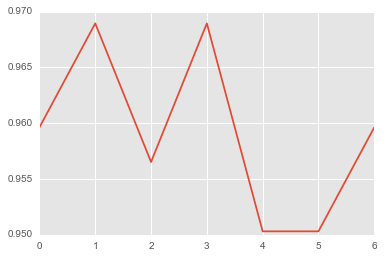

1: 0.962732919255


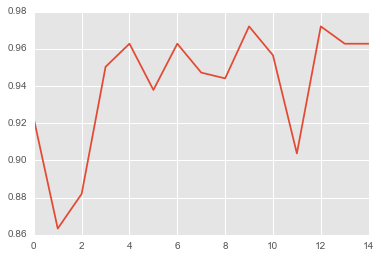

2: 0.968944099379


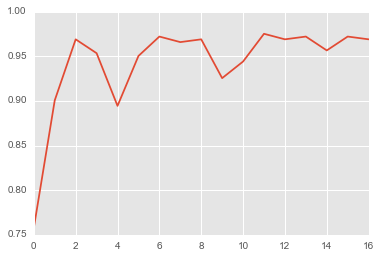

3: 0.984472049689


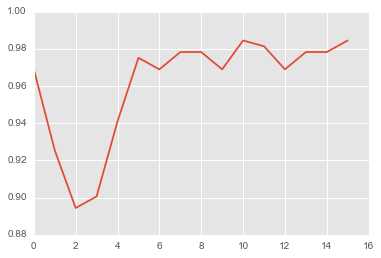

4: 0.975155279503


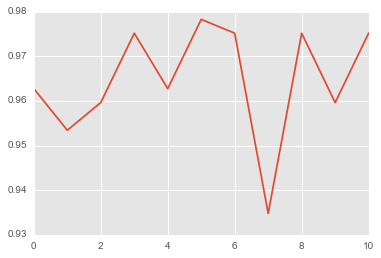

In [193]:
avg_acc = 0
for i in range(5):
    x_train, x_test, y_train, y_test = data.test_train_split(ratio=.7)
    model = Perceptron()
    acc_list, _ = model.train(x_train, y_train, verbose=False)
    print("{}: {}".format(i, acc_list[-1]))
    avg_acc += acc_list[-1]
    y_hat = model.predict(x_test)
    plt.plot(acc_list)
    plt.show()
    
avg_acc = avg_acc / 5

In [194]:
avg_acc

0.97018633540372679

In [186]:
model.w

array([-0.91262638, -0.31828628, -0.10537241, -0.42692691,  1.5461316 ,
        0.16539883, -0.21921843,  0.22787333,  0.43918169, -0.47963421,
        0.19809973, -1.02183832,  0.12526469,  0.38730643,  0.1505826 ,
       -0.4083384 ,  0.18562249])

In [189]:
confusion_matrix(y_test, model.predict(x_test))

array([[79,  3],
       [ 4, 53]])

In [233]:
model = Perceptron()
model.train(x_train, y_train, verbose=False)

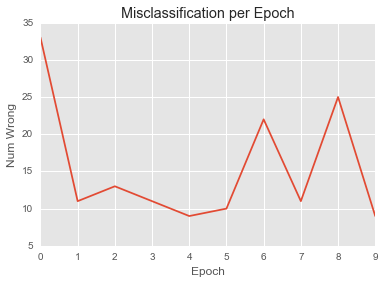

In [235]:
plt.title("Misclassification per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Num Wrong")
plt.plot(model.misclass)

## Problem 6

In [355]:
class MultiPerceptron(BaseLearner):
    """ My implementation of the perceptron algorithm."""
    
    def __init__(self, num_classes=3):
        self.num_classes = num_classes
    
    def train(self, x_train, y_train, lr=.1, epochs=100, verbose=True):
        
        # Initialize a perceptron for each class
        self.p_list = []
        for i in range(self.num_classes):
            pTron = Perceptron()
            class_y_train = np.copy(y_train)
            class_y_train[y_train == i] = 1
            class_y_train[y_train != i] = 0

            pTron.train(x_train, class_y_train, lr=lr, epochs=epochs, verbose=False)
            self.p_list.append(pTron)
            
            
    
    def predict(self, x_test):
        predictions = [0] * self.num_classes
        for i in range(self.num_classes):
            predictions[i] = self.p_list[i].predict(x_test, binary=False)
        
        
        return np.argmax(np.vstack(predictions), axis=0)

In [356]:
data = DataManager('./datasets/iris.arff')

In [366]:
model = MultiPerceptron(3)
model.train(data.data, data.labels)
y_hat = model.predict(data.data)

In [367]:
accuracy_score(data.labels, y_hat)

0.89333333333333331

In [376]:
cm = confusion_matrix(data.labels, y_hat)

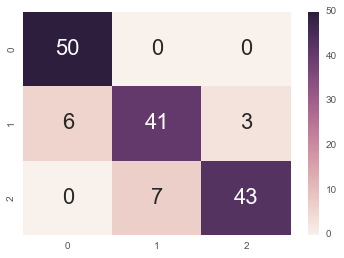

In [378]:
matplotlib.rcParams.update({'font.size': 22})

sns.heatmap(cm, annot=True)
plt.savefig("flower_confussion.png")